<b>Portfolio Variance</b>

In [1]:
import pandas as pd
import pandas_datareader.data as pdr    #Import Libraries
import datetime as dt
import time

C:\Users\akshay\anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
portfolio = {'CONCOR.NS':0.23,'NESTLEIND.NS':0.21,'ASIANPAINT.NS':0.17,'HDFCBANK.NS':0.19,'INFY.NS':0.20}

In [3]:
start_date = dt.datetime.today() - dt.timedelta(735)           # Specify the start and end date
end_date = dt.datetime.today()

In [4]:
class my_portfolio:
    def __init__(self,portfolio,start_date,end_date):  #Initialize the instance variables
        self.portfolio = portfolio
        self.start_date = start_date
        self.end_date = end_date
        self.ticker = list(portfolio.keys())
        self.Wt_Stocks = list(portfolio.values())
    
    def compute(self):
        print('Backtesting portfolio........',end = '\r')
        st_time = time.time() 
        data = pdr.get_data_yahoo(self.ticker,self.start_date,self.end_date)# Get data from Yahoo Finance API
        df_close = data['Adj Close']                               # Extract adjusted close data from whole price data
        df_ret = df_close.pct_change(1).round(4)                   # Find the daily return
        avg_ret = df_ret.iloc[1:df_ret.size].mean().round(4)       # Find the average return over the period
        X = df_ret - avg_ret
        X = X.iloc[1:X.size]                                       #Excess Return Matrix (Excluding NaN value at the top)
        X_n = X.reset_index()                                      # To remove date as datetime index
        X_n.drop(columns = 'Date',inplace = True)
        X_nT = X_n.loc[0:X_n.size,self.ticker[0]:self.ticker[-1]].T          # Transpose of matrix X
        XTX = X_nT.dot(X_n)                                        # Transpose(X) * (X)
        n = len(X_n.axes[0])                                       # Find the number of data points
        var_cov_mtx = (XTX/n).round(5)   
        S_Dev = df_ret.std().round(5)                              # Find the standard deviation of each stock
        S_D = pd.DataFrame(S_Dev)    
        S_DT = S_D.T                                               # Find the transpose of S.D
        Pro_SD = S_D.dot(S_DT).round(5)                            # Dins SD * SDT
        corr_mtx = (var_cov_mtx.div(Pro_SD)).round(5)              # var_cov_mtx * Pro_SD
        Wt_Stocks_df = pd.DataFrame(self.Wt_Stocks)                     # Convert the weight of each stock into a dataframe
        Wt_Stocks_df = Wt_Stocks_df.set_index(S_D.index)           # Set the index same as all others
        Wt_SD = (S_Dev * self.Wt_Stocks).round(5)                       # Find the weighted standard deviation of stocks
        Wt_SD_df = pd.DataFrame(Wt_SD)
        M1 = Wt_SD_df.T.dot(corr_mtx)                              # Transpose(Wt_SD) * Corr_mtx
        M2 = M1.dot(Wt_SD_df)                                      # M1 * Wt_SD
        Port_Var = M2[0].apply('sqrt')                             # Sqrt(M2) = Portfolio Variance or Portfolio S.D
        Port_Var = (Port_Var*100).round(3)
        Annual_Port_SD = (Port_Var*(252**(1/2))).round(2)          # Annual portfolio standard deviation
        Wt_port_ret = Wt_Stocks_df.T.mul(100)                      # Convert stock weights into percentages
        port_dret = pd.concat([Wt_port_ret,df_ret[1:]], ignore_index = True)    # Concatenate previous dataframe to weighted stocks dataframe
        
        for i in range(1,len(port_dret.index)):
            port_dret.iloc[i] = port_dret.iloc[i-1]*(1+port_dret.iloc[i])       # Portfolio's daily returns
        
        port_dret['NAV'] = port_dret.sum(axis = 1)                # Returns in terms of NAV
        port_dret = port_dret.set_index(df_ret.index)             # Set the date index
        per_stock_ret_year =  avg_ret.mul(252)                    # Per stock annual return
        per_stock_ret_year = pd.DataFrame(per_stock_ret_year)
        
        Expected_portfolio_pct_ret = (Wt_Stocks_df.mul(per_stock_ret_year).sum()*100).round(2)   #Expected portfolio return in percent
        NAV_today = port_dret.iloc[-1, -1].round(2)               # NAV as of today        
        NAV = port_dret['NAV']                                    # Plot NAV (Net asset value of portfolio)
        %matplotlib inline
        exec_time = time.time() - st_time
        print('Backtesting done in {} seconds'.format(round(exec_time,2)))
        
        self.exp_ret = Expected_portfolio_pct_ret.tolist()
        self.stdev = Annual_Port_SD.tolist()
        self.nav = NAV
        self.nav_today = NAV_today
        

In [5]:
port = my_portfolio(portfolio,start_date,end_date)

In [6]:
port.compute()

Backtesting done in 11.53 seconds


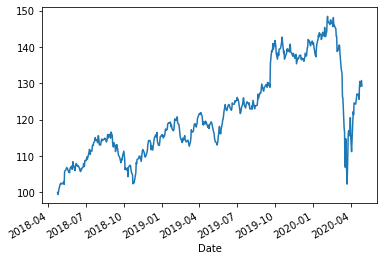

In [7]:
port.nav.plot()